In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
#replace with desired directory
saveTo = "/home/santos/Desktop/thesis-plots";
l=1.5;
dpi=1000;

In [3]:
N = K = 2;
L = 2; #multiple antennas -> vector valued gammas
P = 0.5; 
omega = 1.1;
σₕ = 1.0;
σₙ = σₕ/10;
ϵ = 0.4;



In [4]:
p = QuadTeamProblem(N, N * K * L * ones(Int64, N), L*ones(Int64, N), ComplexF64);
t = teamMMSEproblem(
	P,
	N,
	L,
	K,
	σₕ * ones(Float64, N),
	σₙ * ones(Float64, N),
	ϵ * ones(Float64, N)
);


In [5]:
p = checkProblem(p)

QuadTeamProblem{ComplexF64}(2, [8, 8], [2, 2], ComplexF64)

In [23]:
m_train = 500;
m_test = 1000;
iters = 20;
Y_train, Q_train, R_train = generateTeamMMSEsamples(t, m_train);
Y_test, Q_test, R_test = generateTeamMMSEsamples(t, m_test);

In [24]:
C1 = mean(Q_train[1,2]);
C2 = mean(Q_train[2,1]);

In [25]:
h1 = 1.0;
h2 = 1.0;
λ1 = σₙ^2; #noise variance
λ2 = σₙ^2;

K1(x,t) = matrixExponentialKernel([h1], [C1], [λ1], x, t)
K2(x,t) = matrixExponentialKernel([h2], [C2], [λ2], x, t)
kernels = [K1, K2];
λ = [λ1, λ2];

In [26]:
γj = jacobiSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [27]:
γg = gaussSeidelSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [28]:
γsor = SORSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters, omega=omega);

In [29]:
resJacobi = [residual(m_train, p, kernels, [γj[1][k], γj[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];

In [30]:
resGaussSeidel = [residual(m_train, p, kernels, [γg[1][k], γg[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];

In [31]:
resSOR = [residual(m_train, p, kernels, [γsor[1][k], γsor[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];

In [32]:
resJ  = [[x -> kernelFunction(kernels[i], resJacobi[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];
resG  = [[x -> kernelFunction(kernels[i], resGaussSeidel[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];
resS  = [[x -> kernelFunction(kernels[i], resSOR[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];

In [33]:
perfJ = [GammaNorm(resJ[l], Y_test) for l in 1:iters];
perfG = [GammaNorm(resG[l], Y_test) for l in 1:iters];
perfSOR = [GammaNorm(resS[l], Y_test) for l in 1:iters];

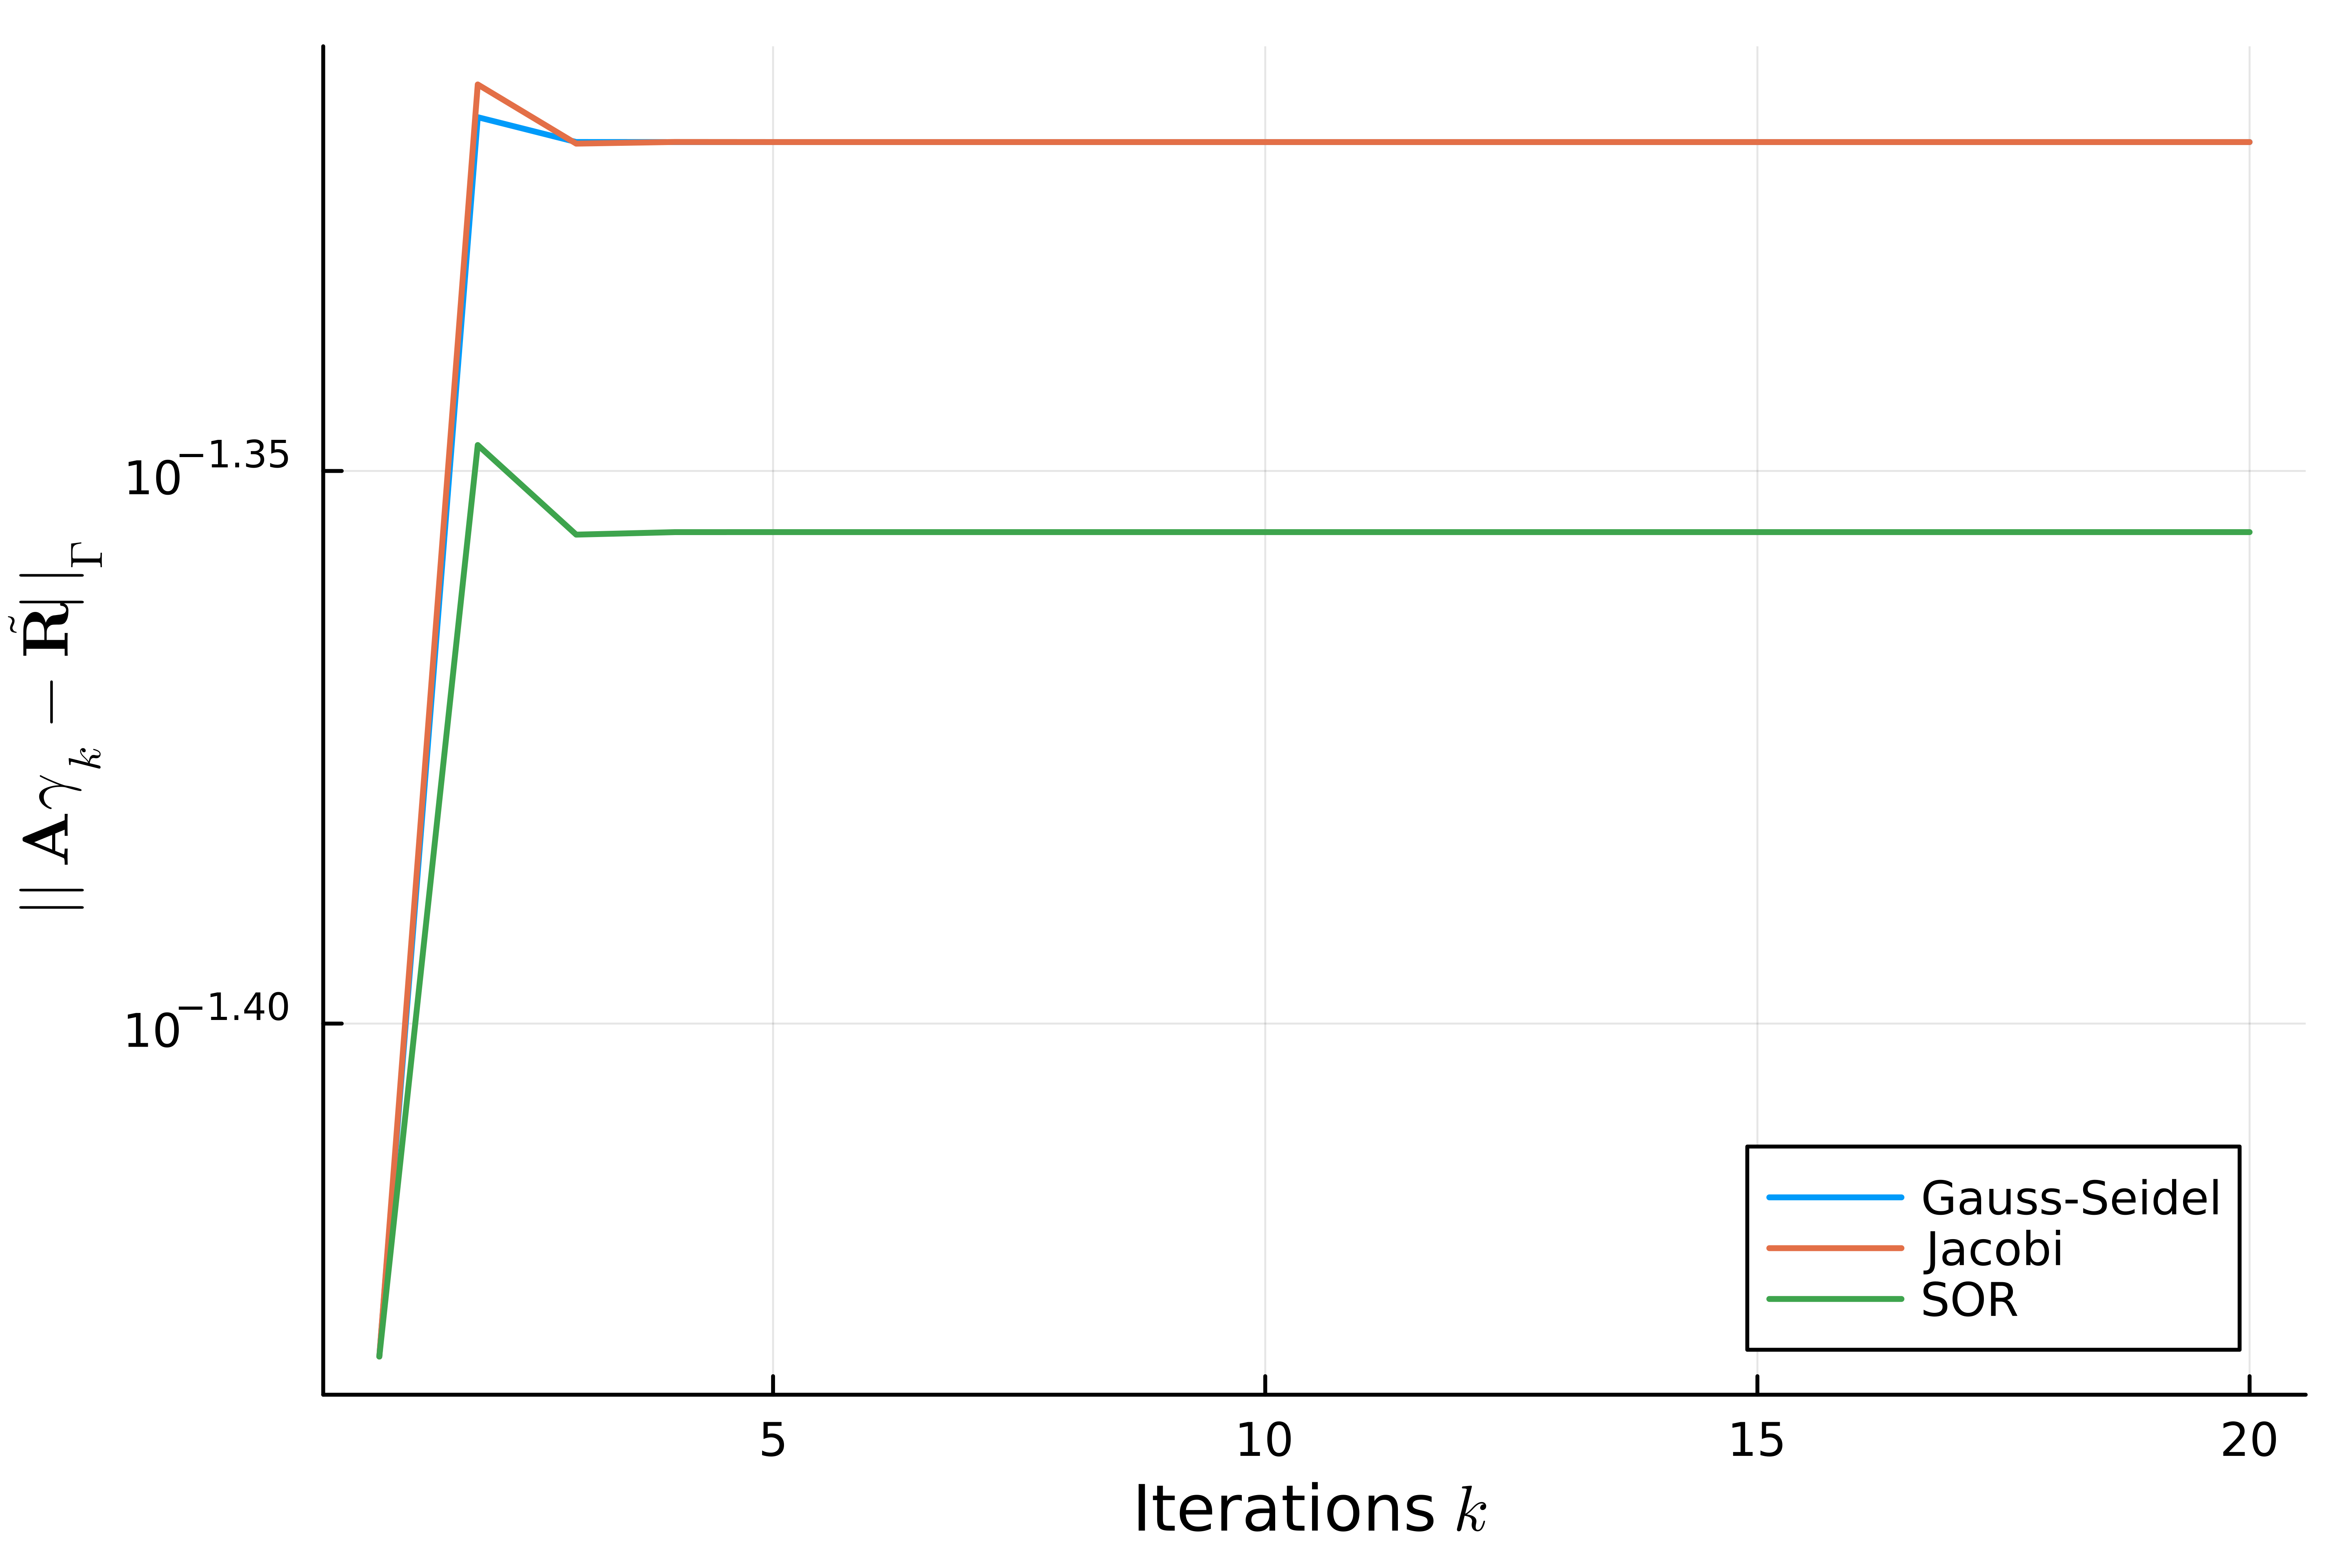

In [34]:
plot(1:iters, [perfG, perfJ, perfSOR], label=["Gauss-Seidel" "Jacobi" "SOR"], yscale=:log10, dpi=dpi, linewidth=l)
xlabel!("Iterations "*L"k")
ylabel!(L"||\mathbf{A}\gamma_k - \mathbf{\tilde{R}}||_{\Gamma}")
savefig(saveTo * "/vector-residual-performance-2-agents.png")
display(Plots.current())

In [35]:
convJ = [diff(γj[i]) for i in 1:p.N];
convG = [diff(γg[i]) for i in 1:p.N];
convS = [diff(γsor[i]) for i in 1:p.N];
strongConvJ = [
	GammaNorm(
		[
			x -> kernelFunction(K1, convJ[1][k], Y_train[1], x),
			x -> kernelFunction(K2, convJ[2][k], Y_train[2], x),
		],
		Y_test,
	) for k in 1:iters
];
strongConvG = [
	GammaNorm(
		[
			x -> kernelFunction(K1, convG[1][k], Y_train[1], x),
			x -> kernelFunction(K2, convG[2][k], Y_train[2], x),
		],
		Y_test,
	) for k in 1:iters
];
strongConvSOR = [
	GammaNorm(
		[
			x -> kernelFunction(K1, convS[1][k], Y_train[1], x),
			x -> kernelFunction(K2, convS[2][k], Y_train[2], x),
		],
		Y_test,
	) for k in 1:iters
];
kernelNormConvJ = [
	sum([kernelNorm(convJ[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];
kernelNormConvG = [
	sum([kernelNorm(convG[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];
kernelNormConvSOR = [
	sum([kernelNorm(convS[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];

In [36]:
using Plots.PlotMeasures

┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -5.443181359167618e-24 found at series index 10 for log10 based yscale
└ @ Plots /home/santos/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -5.443181359167618e-24 found at series index 10 for log10 based yscale
└ @ Plots /home/santos/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -5.443181359167618e-24 found at series index 10 for log10 based yscale
└ @ Plots /home/santos/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


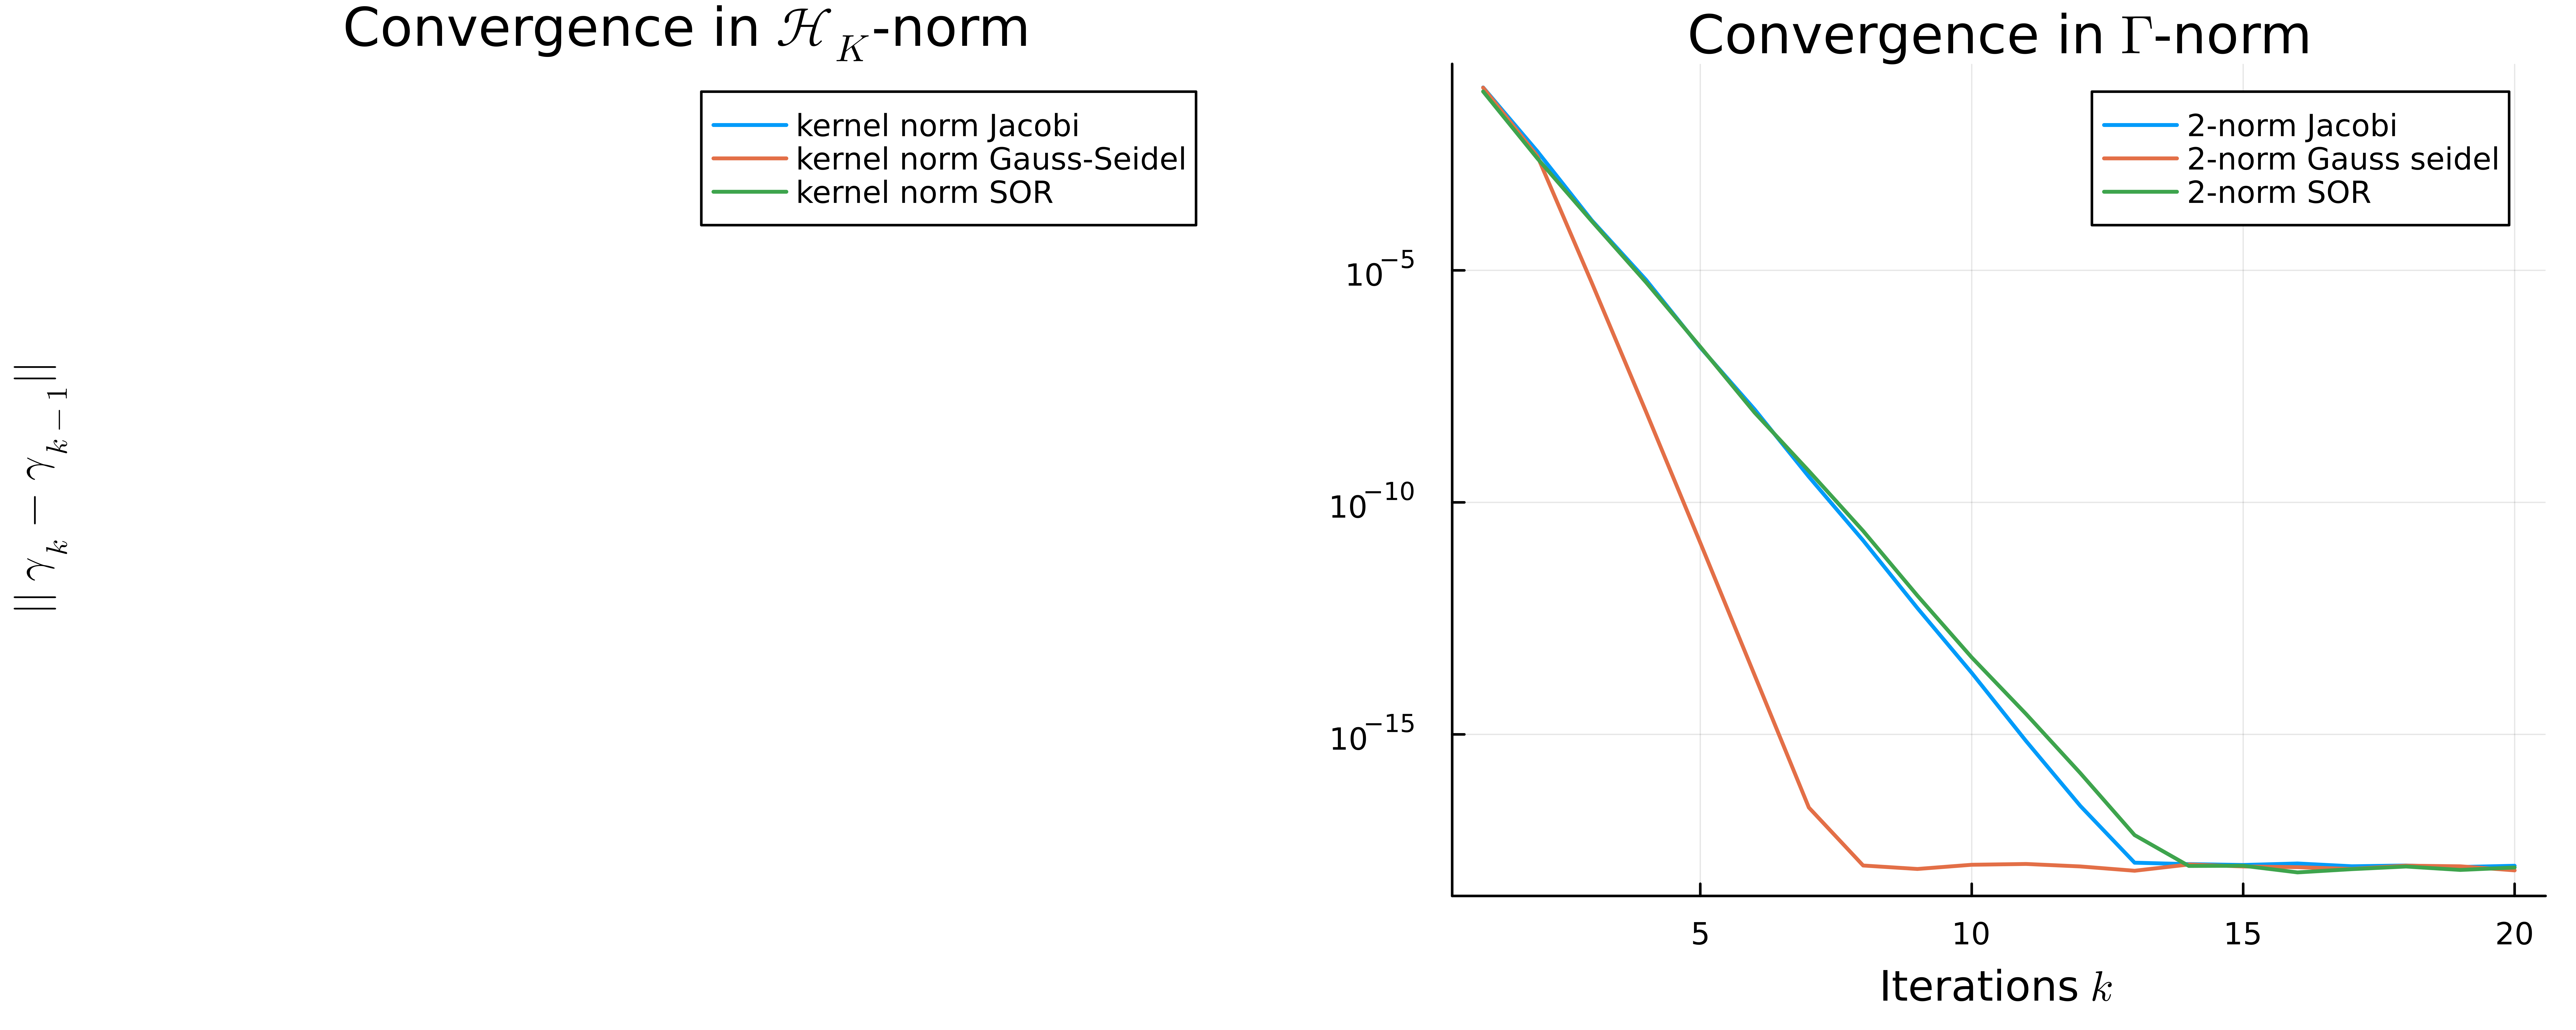

┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/santos/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -5.443181359167618e-24 found at series index 10 for log10 based yscale
└ @ Plots /home/santos/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [37]:
knorm = plot(
	1:iters,
	[kernelNormConvJ, kernelNormConvG, kernelNormConvSOR],
	label = ["kernel norm Jacobi" "kernel norm Gauss-Seidel" "kernel norm SOR"],
	yscale = :log10,
	dpi = dpi, linewidth = l, ylabel = L"||\gamma_k - \gamma_{k-1}||", title = "Convergence in " * L"\mathcal{H}_K" * "-norm"
)
l2norm = plot(
	1:iters,
	[strongConvJ, strongConvG, strongConvSOR],
	label = ["2-norm Jacobi" "2-norm Gauss seidel" "2-norm SOR"],
	yscale = :log10,
	dpi = dpi, linewidth = l, title = "Convergence in " * L"\Gamma" * "-norm"
)
plot(knorm, l2norm, size=(1000,400), left_margin=20px , bottom_margin=20px)
xlabel!("Iterations " * L"k")
savefig(saveTo * "/vector-strong-convergence-performance-2-agents.png")
display(Plots.current())

In [38]:
costPerfJ = [cost(p,
	[
		x -> kernelFunction(K1, γj[1][k], Y_train[1], x),
		x -> kernelFunction(K2, γj[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];
costPerfG = [cost(p,
	[
		x -> kernelFunction(K1, γg[1][k], Y_train[1], x),
		x -> kernelFunction(K2, γg[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];
costPerfSOR = [cost(p,
	[
		x -> kernelFunction(K1, γsor[1][k], Y_train[1], x),
		x -> kernelFunction(K2, γsor[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];

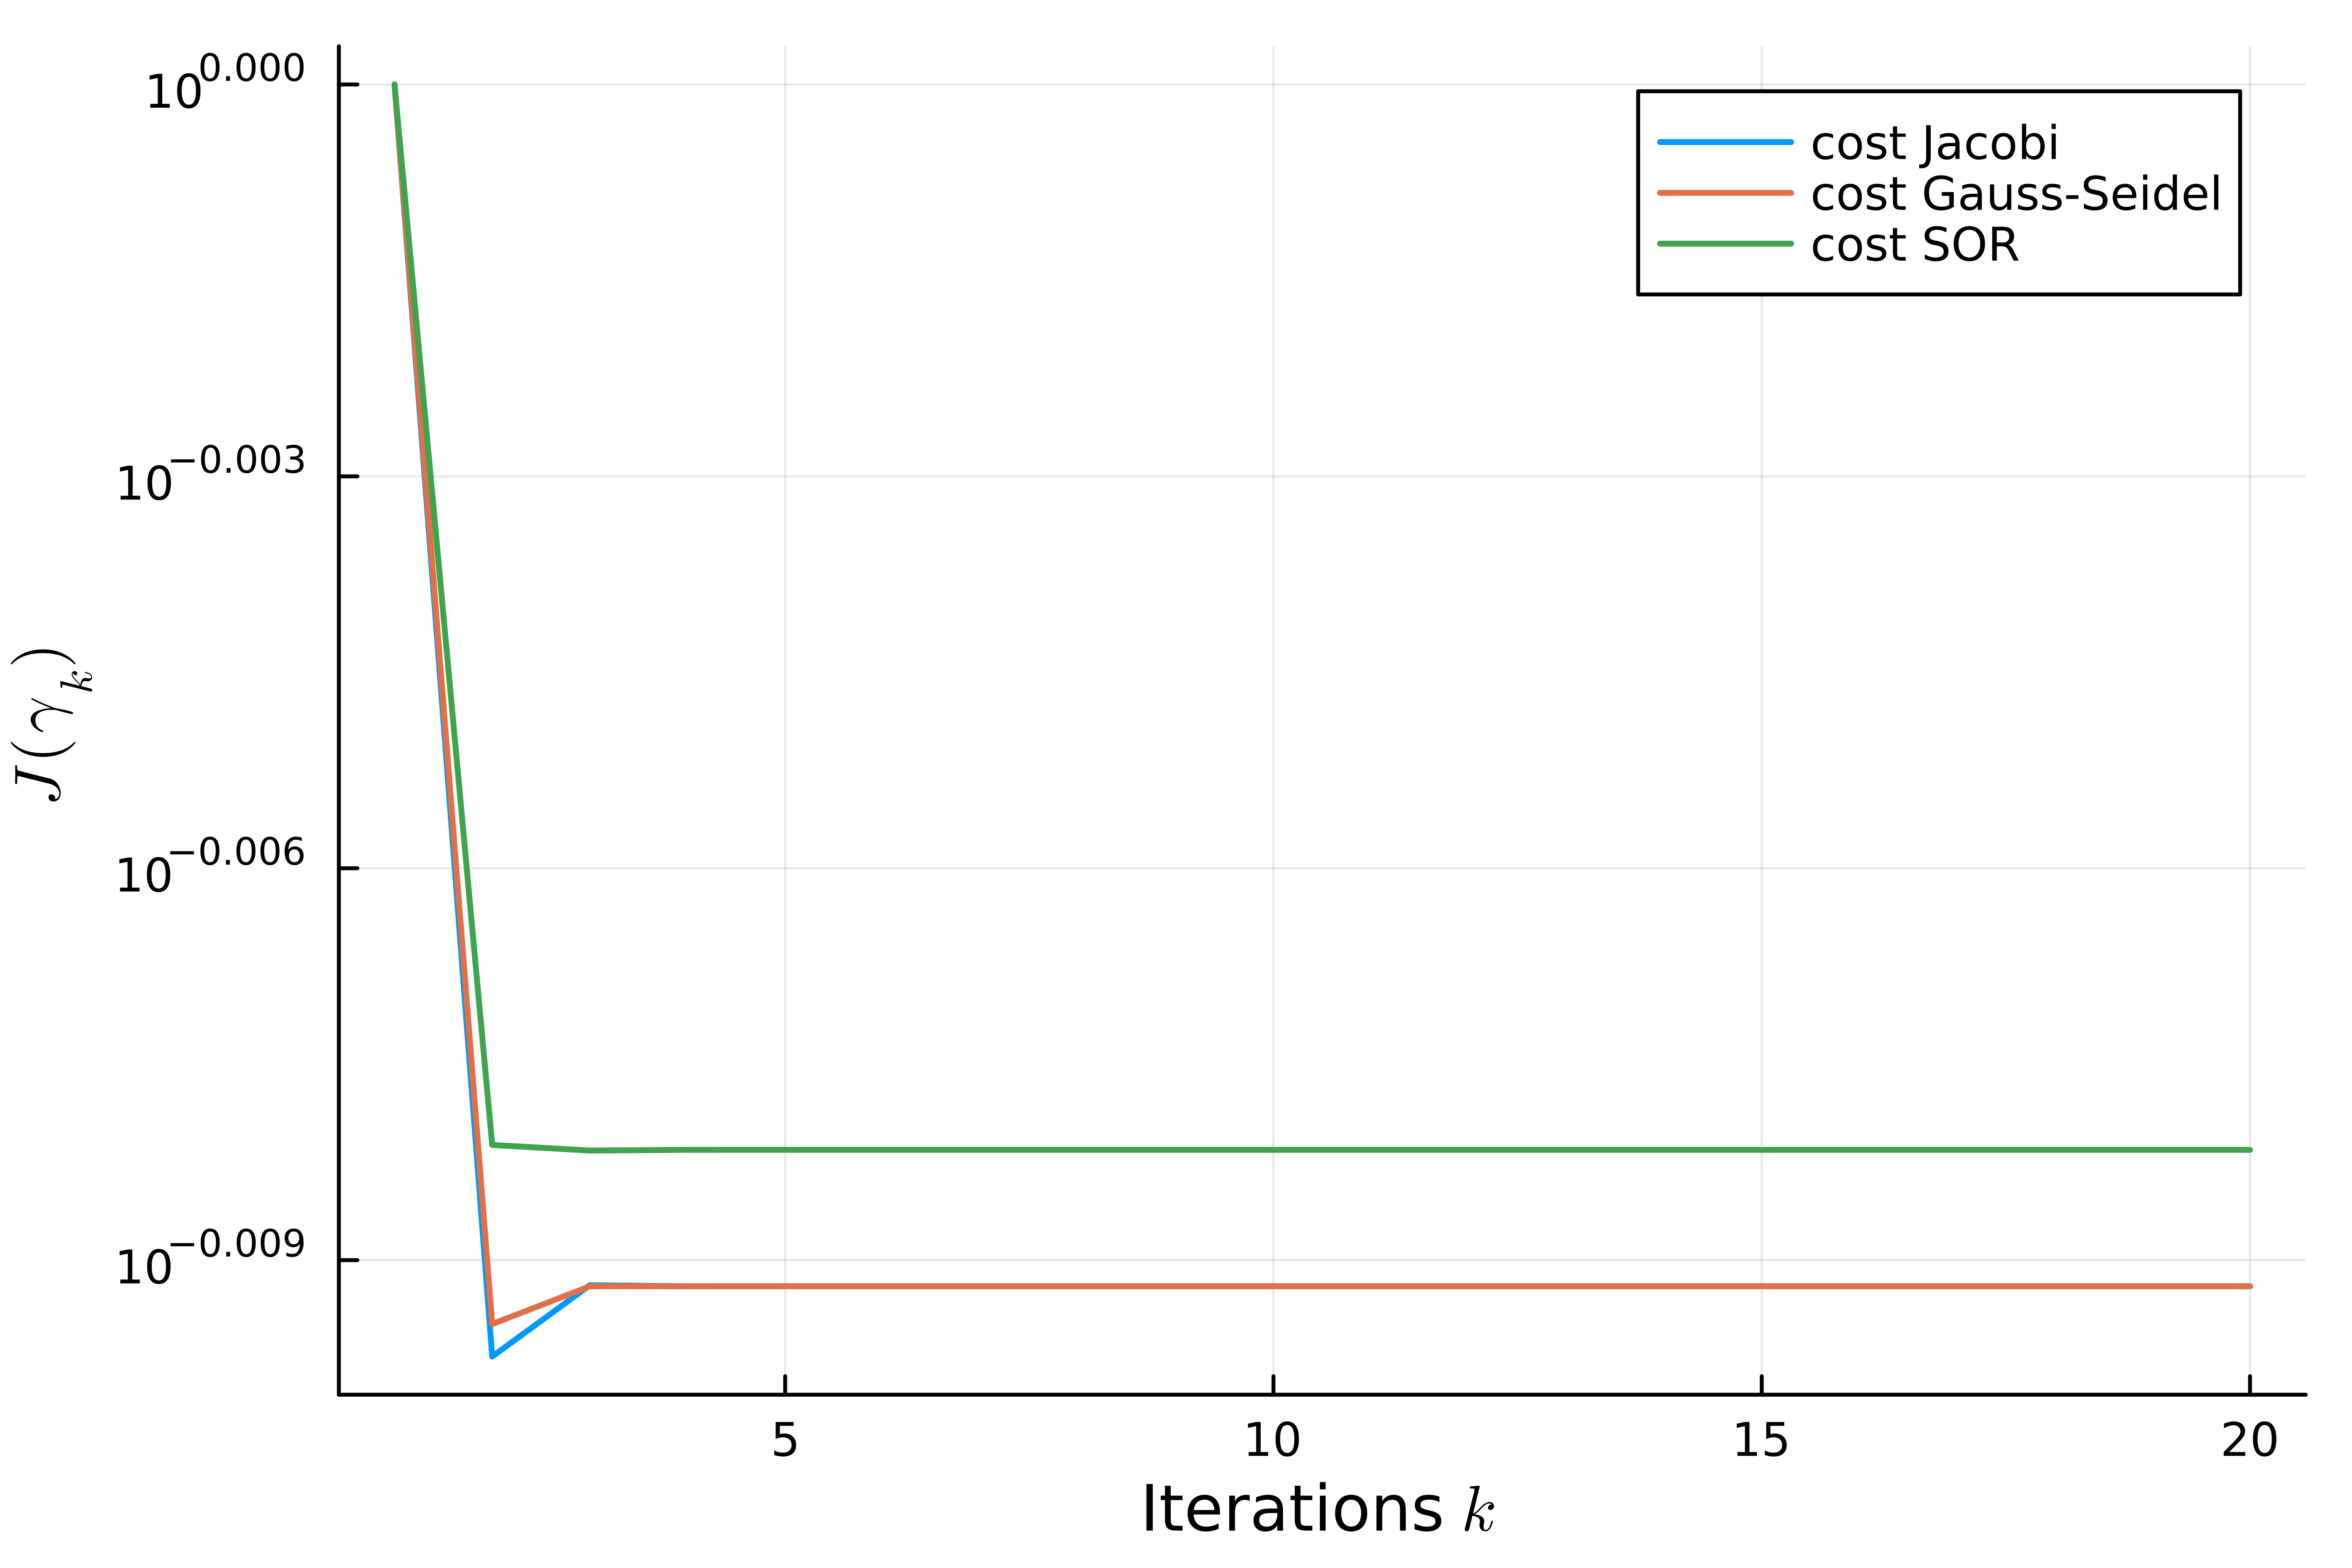

In [39]:
plot(1:iters, [costPerfJ, costPerfG, costPerfSOR], label=["cost Jacobi" "cost Gauss-Seidel" "cost SOR"], yscale=:log10,dpi=dpi, linewidth=l)
xlabel!("Iterations " * L"k")
ylabel!(L"J(\gamma_k)")
savefig(saveTo * "/vector-cost-performance-2-agents.png")
display(Plots.current())